In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import random
#import pyproj
#import shapely.geometry
from tqdm.notebook import tqdm
from math import sin, cos, sqrt, atan2, radians

from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)

In [2]:
# Set the size bins
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,330]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [3]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['impact_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

,high,low,lambda_start,lambda_end,impact_factor
005,16950000,1695000,1.0,2,0.1
005-009,855000,85500,1.1,4,0.2
010-050,146100,14610,1.2,8,0.3
050-100,8700,870,1.4,16,0.6
100+,3050,305,1.8,32,0.8


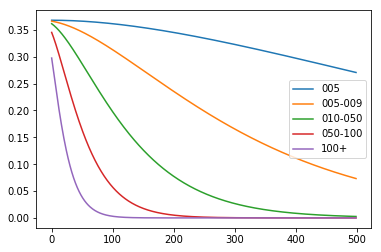

total impacts 7897003.0
impacts by diameter {'005': 7692209.0, '005-009': 168579.0, '010-050': 34139.0, '050-100': 1118.0, '100+': 958.0}
fraction of total {'005': 0.97, '005-009': 0.02, '010-050': 0.0, '050-100': 0.0, '100+': 0.0}


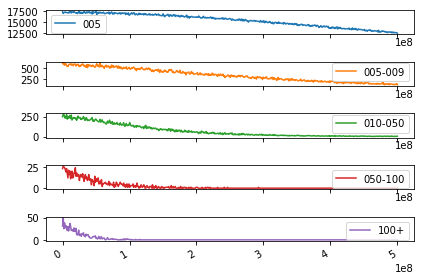

,high,low,lambda_start,lambda_end,impact_factor,total
005,16950000,1695000,1.0,2,0.000021,7692209.0
005-009,855000,85500,1.1,4,0.000624,168579.0
010-050,146100,14610,1.2,8,0.001418,34139.0
050-100,8700,870,1.4,16,0.017678,1118.0
100+,3050,305,1.8,32,0.008155,958.0


In [4]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'impact_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'impact_factor'] = df_freq.loc[d,'impact_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'impact_factor'] = df_freq.loc[d,'impact_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total)
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [5]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [6]:
class IMPAaCS:
    
    def __init__(self, impacts_state, z_layers, impactor_diameter, average_target):
        self.impacts_state = impacts_state
        self.z_layers = z_layers
        self.impactor_diameter = impactor_diameter
        slef.average_target = average_target
    
    def state_dynamics(impacts_state, z_layers, impactor_diameter, average_target):
        """
        This is the critical component of this model
        This function will change the chemical makeup of each grid cell
            according to the chemical theory put forward by Faltys-Wielicki [2021]
        """

        #####      Input parameters (Read from Config file)      #############################
        primitive_initial_state = 45 #sio2
        fraction_upper_layer = 2/3 # d_upper / Mi (from Sudbury)
        fraction_lower_layer = 1/3 # d_lower / Mi (from Sudbury)
        n_layers_impact_melt = 2
        target_SiO2 = 62.58 # From sudbury
        upper_SiO2 = 68.71  # From sudbury
        proportion_melt_from_impact = 1/3

        #####      CONSTANTS             ############################

        #####      DYNAMIC FACTORS       ############################
        depth_of_impact_melt = impactor_diameter * proportion_melt_from_impact

        fracionated_melt = depth_of_impact_melt * fraction_upper_layer #Units: km

        fractionation_factor = 1 - (target_SiO2 / upper_SiO2)

        #####      DO THE DYANMICS       #############################
        # Set lower layer to primitive initial state.  
        for i in range(int(np.ceil(fraction_lower_layer * z_layers)), z_layers):
            impacts_state[i] = primitive_initial_state

        # Impact melt portion  (Upper)
        for i in range(int(np.ceil(fraction_upper_layer * z_layers))):
            impacts_state[i] = average_target / (1 - fractionation_factor)

        # Weighted average of upper    
        wt_sio2_upper = impacts_state[0]

        # Lower of impact melt portion
        upper_melted_layers = int(np.ceil(fraction_upper_layer * z_layers))
        for i in range(int(fraction_upper_layer * upper_melted_layers), upper_melted_layers):
            impacts_state[i] = (average_target-(fraction_upper_layer * wt_sio2_upper))/fraction_lower_layer

        return impacts_state 
    
    
    def Istate_prep(grid_cell_state, z_layers, initial_state_sio2):

        ##### Set the initial state values
        if grid_cell_id not in grid_cell_state.keys():
            grid_cell_state[grid_cell_id] = np.ones(z_layers) * initial_state_sio2

        else: # If there is an existing state key, 
              # and the current impact depth is larger than the z layers, 
              # then extend the z layers
            existing_z_layers = grid_cell_state[grid_cell_id].shape[0]
            if z_layers > existing_z_layers:

                grid_cell_state[grid_cell_id] = np.append(grid_cell_state[grid_cell_id], 
                                            np.ones(z_layers - existing_z_layers) * initial_state_sio2)
        return grid_cell_state

In [7]:
def IMPAaCS(impacts_state, z_layers, impactor_diameter, average_target):
    """
    This is the critical component of this model
    This function will change the chemical makeup of each grid cell
        according to the chemical theory put forward by Faltys-Wielicki [2021]
    """
    
    #####      Input parameters (Read from Config file)      #############################
    primitive_initial_state = 45 #sio2
    fraction_upper_layer = 2/3 # d_upper / Mi (from Sudbury)
    fraction_lower_layer = 1/3 # d_lower / Mi (from Sudbury)
    n_layers_impact_melt = 2
    target_SiO2 = 62.58 # From sudbury
    upper_SiO2 = 68.71  # From sudbury
    proportion_melt_from_impact = 1/3
    
    #####      CONSTANTS             ############################
    
    #####      DYNAMIC FACTORS       ############################
    depth_of_impact_melt = impactor_diameter * proportion_melt_from_impact
    
    fracionated_melt = depth_of_impact_melt * fraction_upper_layer #Units: km
    
    fractionation_factor = 1 - (target_SiO2 / upper_SiO2)
        
    #####      DO THE DYANMICS       #############################
    # Set lower layer to primitive initial state.  
    for i in range(int(np.ceil(fraction_lower_layer * z_layers)), z_layers):
        impacts_state[i] = primitive_initial_state
        
    # Impact melt portion  (Upper)
    for i in range(int(np.ceil(fraction_upper_layer * z_layers))):
        impacts_state[i] = average_target / (1 - fractionation_factor)
        
    # Weighted average of upper    
    wt_sio2_upper = impacts_state[0]
        
    # Lower of impact melt portion
    upper_melted_layers = int(np.ceil(fraction_upper_layer * z_layers))
    for i in range(int(fraction_upper_layer * upper_melted_layers), upper_melted_layers):
        impacts_state[i] = (average_target-(fraction_upper_layer * wt_sio2_upper))/fraction_lower_layer
        
    for i in range(z_layers):
        impacts_state[i] = np.round(impacts_state[i],1)
        
    return impacts_state

In [10]:
def IMPAaCS_state_prep(grid_cell_state, grid_cell_id, z_layers, initial_state_sio2):

    ##### Set the initial state values
    if grid_cell_id not in grid_cell_state.keys():
        grid_cell_state[grid_cell_id] = np.ones(z_layers) * initial_state_sio2

    else: # If there is an existing state key, 
          # and the current impact depth is larger than the z layers, 
          # then extend the z layers
        existing_z_layers = grid_cell_state[grid_cell_id].shape[0]
        if z_layers > existing_z_layers:

            grid_cell_state[grid_cell_id] = np.append(grid_cell_state[grid_cell_id], 
                                        np.ones(z_layers - existing_z_layers) * initial_state_sio2)
    return grid_cell_state

In [27]:
grid_cell_state = {}
z_discretized_km = int(5)
primitive_initial_state = 45
count_test_hits = 0

##### Using this to troubleshoot! 
##### I set each impact to hit the same location, 
##### so there should be a lot of action at a select set of cells.
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")

# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):
            
            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            
            ##### Using this to troubleshoot! 
            ##### I set each impact to hit the same location, 
            ##### so there should be a lot of action at a select set of cells.
            impact_lat = 33.2098        # TROUBLESHOOTING
            impact_lon = -87.5692       # TROUBLESHOOTING
            if random.random() < .25:   # TROUBLESHOOTING
                break                   # TROUBLESHOOTING
            
            # Specify the diameter within the bin
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
            z_layers = int(np.ceil(impactor_diameter/z_discretized_km))
            
            # The impact crator is 10*Diameter, so the radius is half that
            crator_diameter = 10*impactor_diameter
            crator_radius = crator_diameter/2
            
            # Find the grid
            impacted_grid_cells = []
            for ilon in egrid.londim:
                for ilat in egrid.latdim:
                    D = distance(impact_lat,ilat,impact_lon,ilon)
                    if D < crator_radius:
                        impacted_grid_cells.append([ilon, ilat])

            ##################    Get average values from total impacted area
            if it>0:
                average_target = 0
                for grid_cell in impacted_grid_cells:
                    grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))
                    ### If the grid cell has not been hit yet, it is the initial primitive value
                    if grid_cell_id in grid_cell_state.keys():
                        average_target += np.sum(grid_cell_state[grid_cell_id][0:z_layers])
                    else:
                        average_target += primitive_initial_state
                average_target = average_target/(len(impacted_grid_cells) * z_layers)
            else:
                average_target = primitive_initial_state
                            
            # The grid size is 25KM, but the smallest impact is 5KM
            # So if the impactor is smaller than the grid
            # the impact should have a D^2/G^2 change of affecting the chemistry
            # So this means that the grid is just a sample of earth
            # for computational efficiency
            for grid_cell in impacted_grid_cells:
                grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

                ##### Set the initial state values
                grid_cell_state = IMPAaCS_state_prep(grid_cell_state,
                                                     grid_cell_id, 
                                                     z_layers, 
                                                     primitive_initial_state)
                                                
                ################      DO THE DYANMICS       #############################
                grid_cell_state[grid_cell_id] = IMPAaCS(grid_cell_state[grid_cell_id], 
                                                        z_layers, 
                                                        impactor_diameter, 
                                                        average_target)
                
                ##### Testing one cell:
                
                if grid_cell_id == list(grid_cell_state.keys())[0]:
                    count_test_hits+=1
                    print("This is only a test. I am forcing impacts at one location to test the dynamics")
                    print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                                       list(grid_cell_state.keys())[0]))
                    print('average_target: {}, across {} grid cells'.format(np.round(average_target,1), 
                                                                    len(impacted_grid_cells)))
                    print("SiO2 states:")
                    print(list(grid_cell_state[list(grid_cell_state.keys())[0]]))
                
            ##### Using this to troubleshoot! 
            ##### I set each impact to hit the same location, 
            ##### so there should be a lot of action at a select set of cells.
            print(" ")
            break
            
    if it > 15:
        break
        
# Calculate the states for the layers that did not get impacted. Largest Diameter - impacted diamete


This is only a test. I am forcing impacts at one location to test the dynamics
This is only a test. I am forcing impacts at one location to test the dynamics
This is only a test. I am forcing impacts at one location to test the dynamics
time 0
This is only a test. I am forcing impacts at one location to test the dynamics
56 diameter IMPAaC at Test cell: -90.5602 33.2921
average_target: 45, across 188 grid cells
SiO2 states:
[49.4, 49.4, 49.4, 49.4, 49.4, 36.2, 36.2, 36.2, 45.0, 45.0, 45.0, 45.0]
 
This is only a test. I am forcing impacts at one location to test the dynamics
234 diameter IMPAaC at Test cell: -90.5602 33.2921
average_target: 45, across 3299 grid cells
SiO2 states:
[49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 49.4, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 36.2, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
 
time 1
This is only a test

 
time 9
This is only a test. I am forcing impacts at one location to test the dynamics
73 diameter IMPAaC at Test cell: -90.5602 33.2921
average_target: 31.1, across 324 grid cells
SiO2 states:
[34.1, 34.1, 34.1, 34.1, 34.1, 34.1, 25.0, 25.0, 25.0, 25.0, 45.0, 45.0, 45.0, 45.0, 45.0, 24.1, 24.1, 24.1, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 22.4, 22.4, 22.4, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
 
This is only a test. I am forcing impacts at one location to test the dynamics
324 diameter IMPAaC at Test cell: -90.5602 33.2921
average_target: 32.2, across 6305 grid cells
SiO2 states:
[35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 35.3, 25.9, 25.9, 25.9, 25.9, 25.9, 25.9, 25.9, 25.9, 25.9, 2